# PRÁCTICA 4 - VÍCTOR CHOZA MERINO - ADRIÁN TURIEL CHARRO
# Entrenamiento de redes neuronales

## Cargando datos 

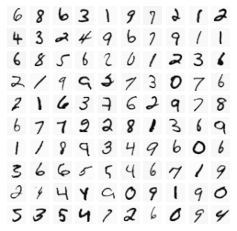

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from scipy.optimize import minimize
import scipy.io

data = loadmat ('ex4data1.mat')
y = data['y'] # (5000,1)
X = data['X'] # (5000,400) Cada fila es una imagen de 20x20 píxeles (400)

mat2=loadmat('ex4weights.mat')
Theta1=mat2["Theta1"] # Theta1 has size 25 x 401  # 25 nodos en la red oculta
Theta2=mat2["Theta2"] # Theta2 has size 10 x 26   # 10 nodos de salida

def dibujar(X): # displayData 
    num_plots = 10
    fig, ax = plt.subplots(num_plots, num_plots,figsize=(4,4))
    for i in range(num_plots):
        for j in range(num_plots):
            img = X[np.random.choice(X.shape[0], 1), :].reshape(20, 20).T
            ax[i][j].imshow(img, cmap='Greys')
            ax[i][j].axis("off")

# Mostramos un conjunto aleatorio          
dibujar(X)

# Ficheros del profe 

In [2]:
def debugInitializeWeights(fan_in, fan_out):
    """
    Initializes the weights of a layer with fan_in incoming connections and
    fan_out outgoing connections using a fixed set of values.
    """

    # Set W to zero matrix
    W = np.zeros((fan_out, fan_in + 1))

    # Initialize W using "sin". This ensures that W is always of the same
    # values and will be useful in debugging.
    W = np.array([np.sin(w) for w in
                  range(np.size(W))]).reshape((np.size(W, 0), np.size(W, 1)))

    return W


def computeNumericalGradient(J, theta):
    """
    Computes the gradient of J around theta using finite differences and
    yields a numerical estimate of the gradient.
    """

    numgrad = np.zeros_like(theta)
    perturb = np.zeros_like(theta)
    tol = 1e-4

    for p in range(len(theta)):
        # Set perturbation vector
        perturb[p] = tol
        loss1 = J(theta - perturb)
        loss2 = J(theta + perturb)

        # Compute numerical gradient
        numgrad[p] = (loss2 - loss1) / (2 * tol)
        perturb[p] = 0

    return numgrad


def checkNNGradients(costNN, reg_param):
    """
    Creates a small neural network to check the back propogation gradients.
    Outputs the analytical gradients produced by the back prop code and the
    numerical gradients computed using the computeNumericalGradient function.
    These should result in very similar values.
    """
    # Set up small NN
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5

    # Generate some random test data
    Theta1 = debugInitializeWeights(hidden_layer_size, input_layer_size)
    Theta2 = debugInitializeWeights(num_labels, hidden_layer_size)

    # Reusing debugInitializeWeights to get random X
    X = debugInitializeWeights(input_layer_size - 1, m)

    # Set each element of y to be in [0,num_labels]
    y = [(i % num_labels) for i in range(m)]

    ys = np.zeros((m, num_labels))
    for i in range(m):
        ys[i, y[i]] = 1

    # Unroll parameters
    nn_params = np.append(Theta1, Theta2).reshape(-1)

    # Compute Cost
    cost, grad = costNN(
        nn_params, input_layer_size, hidden_layer_size, num_labels, X, ys, reg_param)

    def reduced_cost_func(p):
        """ Cheaply decorated nnCostFunction """
        return costNN(p, input_layer_size, hidden_layer_size, num_labels,
                      X, ys, reg_param)[0]

    numgrad = computeNumericalGradient(reduced_cost_func, nn_params)

    # Check two gradients
    np.testing.assert_almost_equal(grad, numgrad)

    return (grad - numgrad)
    #return (np.testing.assert_almost_equal(grad, numgrad))

## Calculando la función de coste y gradiente 
### Coste sin regularización
<img src="csr.png" alt="Similitud" style="width: 600px;" />

### Coste con regularización
<img src="ccr.png" alt="Similitud" />

### Gradiente sin regularización
<img src="gsr.png" alt="Similitud" style="width: 300px;"/>

### Gradiente con regularización
<img src="gcr.png" alt="Similitud" style="width: 500px;"/>

In [3]:
def sigmoide(z): #g(z)
    return (1 / (1 + np.exp(-z)))


def backprop (params_rn, num_entradas, num_ocultas, num_etiquetas, X, y, reg):
    # backprop devuelve una tupla (coste, gradiente) con el coste y el gradiente de
    # una red neuronal de tres capas , con num_entradas , num_ocultas nodos en la capa
    # oculta y num_etiquetas nodos en la capa de salida. Si m es el número de ejemplos
    # de entrenamiento, la dimensión de ’X’ es (m, num_entradas) y la de ’y’ es
    # (m, num_etiquetas)

    Theta1 = np.reshape(params_rn[:num_ocultas * (num_entradas + 1)],
                        (num_ocultas, (num_entradas + 1)))
    Theta2 = np.reshape(params_rn[num_ocultas * (num_entradas + 1):],
                        (num_etiquetas, (num_ocultas + 1)))

    J=0
    m = X.shape[0]

    a1 = np.hstack((np.ones((m,1)), X))
    a2 = sigmoide(a1 @ Theta1.T)
    a2 = np.hstack((np.ones((m,1)), a2))
    h = sigmoide(a2 @ Theta2.T)

    for i in range(num_etiquetas):
        H = h[:,i]
        J = J + np.log(H).T @ -y[:,i] - (1-np.ravel(y[:,i])) @ np.log(1-H)

    coste = J/m
    coste_regularizado = coste + reg/(2*m) * (np.sum(Theta1[:,1:]**2)
                                              + np.sum(Theta2[:,1:]**2))

    Delta1 = np.zeros((Theta1.shape))
    Delta2 = np.zeros((Theta2.shape))

    for t in range(m):
        a1t = a1[t, :] # (401,)
        a2t = a2[t, :] # (26,)
        ht = h[t, :] # (10,)
        yt = y[t] # (10,)
        d3t = ht - yt # (10,)
        d2t = np.dot(Theta2.T, d3t) * (a2t * (1 - a2t)) # (26,)
        Delta1 = Delta1 + np.dot(d2t[1:, np.newaxis], a1t[np.newaxis, :])
        Delta2 = Delta2 + np.dot(d3t[:, np.newaxis], a2t[np.newaxis, :])

    Delta1 = Delta1/m
    Delta2 = Delta2/m
    
    Delta1_reg = Delta1 + (reg/m) * np.hstack(
        (np.zeros((Theta1.shape[0],1)),Theta1[:,1:]))
    Delta2_reg = Delta2 + (reg/m) * np.hstack(
        (np.zeros((Theta2.shape[0],1)),Theta2[:,1:]))

    return (coste_regularizado, np.append(Delta1_reg,Delta2_reg))


In [4]:
# Comprobacion para los costes
params_rn = np.append(Theta1.flatten(),Theta2.flatten())

num_entradas  = np.shape(X)[1]      # 400
num_ocultas = np.shape(Theta1)[0]   # 25       Asi valdra para cualquier red neuronal
num_etiquetas = np.shape(Theta2)[0] # 10

Y = np.zeros((X.shape[0],num_etiquetas))      # Convertimos y en vector Y
for i in range(1,num_etiquetas+1):
    Y[:,i-1][:,np.newaxis] = np.where(y==i,1,0)
    
reg = 0    
J_sin_reg = backprop(params_rn, num_entradas,
                     num_ocultas, num_etiquetas, X, Y, reg)[0]

reg = 1
J_con_reg = backprop(params_rn, num_entradas,
                     num_ocultas, num_etiquetas, X, Y, reg)[0]

print("Coste (sin regularizar):",J_sin_reg,"\nCoste (regularizado):",J_con_reg)

Coste (sin regularizar): 0.287629165161319 
Coste (regularizado): 0.3837698590909237


In [5]:
# Comprobacion gradiente
# 0 equivqle a SIN regularizacion y 1 a CON regularizacion
checkNNGradients(backprop, reg)    # devuelve la diferencia entre los real y lo obtenido

array([ 5.49965629e-11,  7.32747196e-13,  4.38898917e-12,  7.53047624e-12,
       -6.08260664e-11,  2.10970130e-12, -1.60946534e-11, -4.48128479e-11,
       -9.29989974e-11,  1.00357500e-11, -4.12793411e-11, -1.22203025e-10,
       -2.17855040e-11,  4.35645964e-12, -7.00919878e-12, -2.43030734e-11,
        2.15736526e-11,  2.27595720e-13,  9.77740458e-12,  2.84505197e-11,
        6.25964836e-11,  1.38673517e-11,  6.28552765e-12,  5.29278010e-12,
        1.81106935e-11,  1.78381754e-11,  7.15513759e-11,  1.19340093e-11,
        5.64423508e-12,  1.17110627e-11,  1.64833147e-11,  1.95246597e-11,
        7.55120411e-11,  1.66865410e-11,  8.55090998e-12,  1.63125347e-11,
        1.34624811e-11,  1.99839867e-11])

## Aprendizaje de los parámetros 

In [6]:
def propagacion_hacia_adelante(Theta1, Theta2, X):
    m = X.shape[0]
    X = np.hstack((np.ones((m,1)),X))
    
    a1 = sigmoide(X @ Theta1.T)
    a1 = np.hstack((np.ones((m,1)), a1)) 
    a2 = sigmoide(a1 @ Theta2.T) # h       
    
    return a2

def porcentaje_acertado(X, y, H):
    
    pos_max = np.argmax(H,axis=1)+1
    suma = sum(pos_max[:,np.newaxis]==y)
                
    return ((suma/np.shape(H)[0])*100)[0]

In [7]:
INIT_EPSILON = 0.12

Rand_Theta1 = np.random.random(
    (num_ocultas,num_entradas+1))*(2*INIT_EPSILON) - INIT_EPSILON
Rand_Theta2 = np.random.random(
    (num_etiquetas,num_ocultas+1))*(2*INIT_EPSILON) - INIT_EPSILON

params_rn = np.append(Rand_Theta1.flatten(),Rand_Theta2.flatten())

fmin = minimize(fun=backprop, x0=params_rn,
     args=(num_entradas, num_ocultas,
     num_etiquetas, X, Y, reg),
     method='TNC', jac=True,
     options={'maxiter': 70})

print(fmin)

     fun: 0.5739859241141538
     jac: array([-2.46303230e-04, -3.85821455e-06, -6.10009135e-06, ...,
        1.22847177e-03,  2.44968440e-03,  2.73230948e-03])
 message: 'Max. number of function evaluations reached'
    nfev: 70
     nit: 12
  status: 3
 success: False
       x: array([ 0.40058545, -0.01929107, -0.03050046, ...,  2.61887429,
       -2.67948041, -0.39788641])


In [8]:
result = fmin.x
theta1 = result[:(num_ocultas *
                  (num_entradas + 1))].reshape((num_ocultas,num_entradas + 1))
theta2 = result[-((num_ocultas + 1) *
                  num_etiquetas):].reshape((num_etiquetas, num_ocultas + 1))

H = propagacion_hacia_adelante(theta1, theta2, X)
print("\n Precisión:",porcentaje_acertado(X, y, H),"%") 


 Precisión: 93.94 %
